<a href="https://colab.research.google.com/github/Yassa122/VideoFeatureExtractionUsingDeepLearning/blob/main/AML_PROJ_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Action Recognition with an Inflated 3D CNN


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/hub/tutorials/action_recognition_with_tf_hub.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/hub/tutorials/action_recognition_with_tf_hub.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/hub/tutorials/action_recognition_with_tf_hub.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/deepmind/i3d-kinetics-400/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

This Colab demonstrates recognizing actions in video data using the
[tfhub.dev/deepmind/i3d-kinetics-400/1](https://tfhub.dev/deepmind/i3d-kinetics-400/1) module. More models to detect actions in videos can be found [here](https://tfhub.dev/s?module-type=video-classification).

The underlying model is described in the paper "[Quo Vadis, Action Recognition? A New
Model and the Kinetics Dataset](https://arxiv.org/abs/1705.07750)" by Joao
Carreira and Andrew Zisserman. The paper was posted on arXiv in May 2017, and
was published as a CVPR 2017 conference paper.
The source code is publicly available on
[github](https://github.com/deepmind/kinetics-i3d).

"Quo Vadis" introduced a new architecture for video classification, the Inflated
3D Convnet or I3D. This architecture achieved state-of-the-art results on the UCF101
and HMDB51 datasets from fine-tuning these models. I3D models pre-trained on Kinetics
also placed first in the CVPR 2017 [Charades challenge](http://vuchallenge.org/charades.html).

The original module was trained on the [kinetics-400 dateset](https://www.deepmind.com/open-source/kinetics)
and knows about 400 different actions.
Labels for these actions can be found in the
[label map file](https://github.com/deepmind/kinetics-i3d/blob/master/data/label_map.txt).

In this Colab we will use it recognize activities in videos from a UCF101 dataset.

## Setup

In [ ]:
!pip install -q imageio
!pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [ ]:
#@title Import the necessary modules
# TensorFlow and TF-Hub modules.
from absl import logging

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed

logging.set_verbosity(logging.ERROR)

# Some modules to help with reading the UCF101 dataset.
import random
import re
import os
import tempfile
import ssl
import cv2
import numpy as np

# Some modules to display an animation using imageio.
import imageio
from IPython import display

from urllib import request  # requires python3

In [ ]:
#@title Helper functions for the UCF101 dataset

# Utilities to fetch videos from UCF101 dataset
UCF_ROOT = "https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/"
_VIDEO_LIST = None
_CACHE_DIR = tempfile.mkdtemp()
# As of July 2020, crcv.ucf.edu doesn't use a certificate accepted by the
# default Colab environment anymore.
unverified_context = ssl._create_unverified_context()

def list_ucf_videos():
  """Lists videos available in UCF101 dataset."""
  global _VIDEO_LIST
  if not _VIDEO_LIST:
    index = request.urlopen(UCF_ROOT, context=unverified_context).read().decode("utf-8")
    videos = re.findall("(v_[\w_]+\.avi)", index)
    _VIDEO_LIST = sorted(set(videos))
  return list(_VIDEO_LIST)

def fetch_ucf_video(video):
  """Fetches a video and cache into local filesystem."""
  cache_path = os.path.join(_CACHE_DIR, video)
  if not os.path.exists(cache_path):
    urlpath = request.urljoin(UCF_ROOT, video)
    print("Fetching %s => %s" % (urlpath, cache_path))
    data = request.urlopen(urlpath, context=unverified_context).read()
    open(cache_path, "wb").write(data)
  return cache_path

# Utilities to open video files using CV2
def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

def load_video(path, max_frames=0, resize=(224, 224)):
  cap = cv2.VideoCapture(path)
  frames = []
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = crop_center_square(frame)
      frame = cv2.resize(frame, resize)
      frame = frame[:, :, [2, 1, 0]]
      frames.append(frame)

      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  return np.array(frames) / 255.0

def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, duration=40)
  return embed.embed_file('./animation.gif')

In [ ]:
#@title Get the kinetics-400 labels
# Get the kinetics-400 action labels from the GitHub repository.
KINETICS_URL = "https://raw.githubusercontent.com/deepmind/kinetics-i3d/master/data/label_map.txt"
with request.urlopen(KINETICS_URL) as obj:
  labels = [line.decode("utf-8").strip() for line in obj.readlines()]
print("Found %d labels." % len(labels))

Found 400 labels.


# Using the UCF101 dataset

In [ ]:
# Get the list of videos in the dataset.
ucf_videos = list_ucf_videos()

categories = {}
for video in ucf_videos:
  category = video[2:-12]
  if category not in categories:
    categories[category] = []
  categories[category].append(video)
print("Found %d videos in %d categories." % (len(ucf_videos), len(categories)))

for category, sequences in categories.items():
  summary = ", ".join(sequences[:2])
  print("%-20s %4d videos (%s, ...)" % (category, len(sequences), summary))


Found 13320 videos in 101 categories.
ApplyEyeMakeup        145 videos (v_ApplyEyeMakeup_g01_c01.avi, v_ApplyEyeMakeup_g01_c02.avi, ...)
ApplyLipstick         114 videos (v_ApplyLipstick_g01_c01.avi, v_ApplyLipstick_g01_c02.avi, ...)
Archery               145 videos (v_Archery_g01_c01.avi, v_Archery_g01_c02.avi, ...)
BabyCrawling          132 videos (v_BabyCrawling_g01_c01.avi, v_BabyCrawling_g01_c02.avi, ...)
BalanceBeam           108 videos (v_BalanceBeam_g01_c01.avi, v_BalanceBeam_g01_c02.avi, ...)
BandMarching          155 videos (v_BandMarching_g01_c01.avi, v_BandMarching_g01_c02.avi, ...)
BaseballPitch         150 videos (v_BaseballPitch_g01_c01.avi, v_BaseballPitch_g01_c02.avi, ...)
BasketballDunk        131 videos (v_BasketballDunk_g01_c01.avi, v_BasketballDunk_g01_c02.avi, ...)
Basketball            134 videos (v_Basketball_g01_c01.avi, v_Basketball_g01_c02.avi, ...)
BenchPress            160 videos (v_BenchPress_g01_c01.avi, v_BenchPress_g01_c02.avi, ...)
Biking              

In [ ]:
# Get a sample cricket video.
video_path = fetch_ucf_video("v_CricketShot_g04_c02.avi")
sample_video = load_video(video_path)

Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_CricketShot_g04_c02.avi => /tmp/tmpl562x0t5/v_CricketShot_g04_c02.avi


In [ ]:
sample_video.shape

(116, 224, 224, 3)

In [ ]:
i3d = hub.load("https://tfhub.dev/deepmind/i3d-kinetics-400/1").signatures['default']

Run the id3 model and print the top-5 action predictions.

In [ ]:
def predict(sample_video):
  # Add a batch axis to the sample video.
  model_input = tf.constant(sample_video, dtype=tf.float32)[tf.newaxis, ...]

  logits = i3d(model_input)['default'][0]
  probabilities = tf.nn.softmax(logits)

  print("Top 5 actions:")
  for i in np.argsort(probabilities)[::-1][:5]:
    print(f"  {labels[i]:22}: {probabilities[i] * 100:5.2f}%")

In [ ]:
predict(sample_video)

Top 5 actions:
  playing cricket       : 97.77%
  skateboarding         :  0.71%
  robot dancing         :  0.56%
  roller skating        :  0.56%
  golf putting          :  0.13%


Now try a new video, from: https://commons.wikimedia.org/wiki/Category:Videos_of_sports

How about [this video](https://commons.wikimedia.org/wiki/File:End_of_a_jam.ogv) by Patrick Gillett:

In [ ]:
!curl -O https://upload.wikimedia.org/wikipedia/commons/8/86/End_of_a_jam.ogv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 55.0M  100 55.0M    0     0  22.8M      0  0:00:02  0:00:02 --:--:-- 22.8M


In [ ]:
video_path = "End_of_a_jam.ogv"

In [ ]:
sample_video = load_video(video_path)[:100]
sample_video.shape

(100, 224, 224, 3)


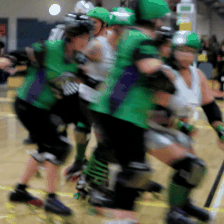

In [ ]:
to_gif(sample_video)

In [ ]:
predict(sample_video)

Top 5 actions:
  roller skating        : 96.85%
  playing volleyball    :  1.63%
  skateboarding         :  0.21%
  playing ice hockey    :  0.20%
  playing basketball    :  0.16%


In [ ]:
# 1 Dataset


import pandas as pd

# Define a function to extract labels from video paths
def extract_label(video_path):
    return video_path.split('/')[-1].split('_')[1]

# Iterate through the list of video paths, extract labels, and create a dataframe
video_paths = list_ucf_videos()
data = {'video_path': video_paths, 'label': [extract_label(path) for path in video_paths]}
df = pd.DataFrame(data)

# Display the dataframe
print(df.head())


# Filter the DataFrame to include only the specified categories
filtered_df = df[df['label'].isin(['BlowingCandles', 'BodyWeightSquats', 'Bowling'])]

# Display the filtered DataFrame
print(filtered_df)


                     video_path           label
0  v_ApplyEyeMakeup_g01_c01.avi  ApplyEyeMakeup
1  v_ApplyEyeMakeup_g01_c02.avi  ApplyEyeMakeup
2  v_ApplyEyeMakeup_g01_c03.avi  ApplyEyeMakeup
3  v_ApplyEyeMakeup_g01_c04.avi  ApplyEyeMakeup
4  v_ApplyEyeMakeup_g01_c05.avi  ApplyEyeMakeup
                        video_path           label
1789  v_BlowingCandles_g01_c01.avi  BlowingCandles
1790  v_BlowingCandles_g01_c02.avi  BlowingCandles
1791  v_BlowingCandles_g01_c03.avi  BlowingCandles
1792  v_BlowingCandles_g01_c04.avi  BlowingCandles
1793  v_BlowingCandles_g02_c01.avi  BlowingCandles
...                            ...             ...
2160         v_Bowling_g25_c01.avi         Bowling
2161         v_Bowling_g25_c02.avi         Bowling
2162         v_Bowling_g25_c03.avi         Bowling
2163         v_Bowling_g25_c04.avi         Bowling
2164         v_Bowling_g25_c05.avi         Bowling

[376 rows x 2 columns]


In [ ]:
# Download videos using fetch_ucf_video
for index, row in filtered_df.iterrows():
    video_path = row['video_path']
    fetch_ucf_video(video_path)


Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_BlowingCandles_g01_c01.avi => /tmp/tmpl562x0t5/v_BlowingCandles_g01_c01.avi
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_BlowingCandles_g01_c02.avi => /tmp/tmpl562x0t5/v_BlowingCandles_g01_c02.avi
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_BlowingCandles_g01_c03.avi => /tmp/tmpl562x0t5/v_BlowingCandles_g01_c03.avi
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_BlowingCandles_g01_c04.avi => /tmp/tmpl562x0t5/v_BlowingCandles_g01_c04.avi
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_BlowingCandles_g02_c01.avi => /tmp/tmpl562x0t5/v_BlowingCandles_g02_c01.avi
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_BlowingCandles_g02_c02.avi => /tmp/tmpl562x0t5/v_BlowingCandles_g02_c02.avi
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_BlowingCandles_g02_c03.avi => /tmp/tmpl562x0t5/v_BlowingCandles_g02_c03.avi
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF10

In [ ]:
# 2 Data Preprocessing


import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Apply preprocessing steps on each frame
def preprocess_frame(frame, target_size=(224, 224)):
    # Resize the frame to the target size
    resized_frame = cv2.resize(frame, target_size)
    # Convert the frame to RGB format (assuming the input is in BGR)
    rgb_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
    return rgb_frame
# Define helper method to extract frames from videos
def extract_frames(video_path, max_frames=0):
    cap = cv2.VideoCapture(video_path)
    frames = []
    try:
        frame_count = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            # Preprocess the frame
            preprocessed_frame = preprocess_frame(frame)
            frames.append(preprocessed_frame)
            frame_count += 1

            if max_frames != 0 and frame_count == max_frames:
                break
    finally:
        cap.release()

    return frames


# extract and preprocess frames
preprocessed_frames = []
for index, row in filtered_df.iterrows():
    video_path = '/tmp/tmpl562x0t5/' + row['video_path']  # Add prefix to the video path
    frames = extract_frames(video_path, 30)
    print(f"Extracted {len(frames)} frames from {video_path}")
    preprocessed_frames.extend(frames)


preprocessed_frames = np.array(preprocessed_frames)
print("Shape of preprocessed frames array:", preprocessed_frames.shape)



# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Further split the training set into training and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Print the sizes of the resulting sets
print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))
print("Testing set size:", len(test_df))



Extracted 30 frames from /tmp/tmpl562x0t5/v_BlowingCandles_g01_c01.avi
Extracted 30 frames from /tmp/tmpl562x0t5/v_BlowingCandles_g01_c02.avi
Extracted 30 frames from /tmp/tmpl562x0t5/v_BlowingCandles_g01_c03.avi
Extracted 30 frames from /tmp/tmpl562x0t5/v_BlowingCandles_g01_c04.avi
Extracted 30 frames from /tmp/tmpl562x0t5/v_BlowingCandles_g02_c01.avi
Extracted 30 frames from /tmp/tmpl562x0t5/v_BlowingCandles_g02_c02.avi
Extracted 30 frames from /tmp/tmpl562x0t5/v_BlowingCandles_g02_c03.avi
Extracted 30 frames from /tmp/tmpl562x0t5/v_BlowingCandles_g02_c04.avi
Extracted 30 frames from /tmp/tmpl562x0t5/v_BlowingCandles_g03_c01.avi
Extracted 30 frames from /tmp/tmpl562x0t5/v_BlowingCandles_g03_c02.avi
Extracted 30 frames from /tmp/tmpl562x0t5/v_BlowingCandles_g03_c03.avi
Extracted 30 frames from /tmp/tmpl562x0t5/v_BlowingCandles_g03_c04.avi
Extracted 30 frames from /tmp/tmpl562x0t5/v_BlowingCandles_g04_c01.avi
Extracted 30 frames from /tmp/tmpl562x0t5/v_BlowingCandles_g04_c02.avi
Extrac

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Load the pre-trained InceptionV3 model without the top classification layers
base_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')

# Define a function to extract features from a batch of preprocessed frames using the InceptionV3 model
def extract_features_from_frames_batch(frames_batch):
    # Preprocess the frames for the InceptionV3 model
    preprocessed_frames_batch = preprocess_input(frames_batch.astype('float32'))

    # Extract features from the preprocessed frames using the InceptionV3 model
    features_batch = base_model.predict(preprocessed_frames_batch)
    return features_batch

# Define the batch size for feature extraction
batch_size = 32

# Apply feature extraction on the preprocessed frames in batches
num_frames = len(preprocessed_frames)
extracted_features_batches = []

for i in range(0, num_frames, batch_size):
    frames_batch = preprocessed_frames[i:i+batch_size]
    features_batch = extract_features_from_frames_batch(frames_batch)
    extracted_features_batches.append(features_batch)

# Concatenate the extracted features from all batches
extracted_features = np.concatenate(extracted_features_batches, axis=0)

# Verify the shape of the extracted features
print("Shape of extracted features array:", extracted_features.shape)


1/1 [==============================] - 3s 3s/step
Shape of extracted features array: (11280, 2048)


Epoch 1/50
8/8 [==============================] - 4s 127ms/step - loss: 3.0492 - accuracy: 0.2978 - val_loss: 2.8252 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/50
8/8 [==============================] - 0s 23ms/step - loss: 2.7006 - accuracy: 0.3333 - val_loss: 2.5109 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 2.4079 - accuracy: 0.3689 - val_loss: 2.2516 - val_accuracy: 0.3733 - lr: 0.0010
Epoch 4/50
8/8 [==============================] - 0s 19ms/step - loss: 2.1697 - accuracy: 0.3378 - val_loss: 2.0449 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 5/50
8/8 [==============================] - 0s 19ms/step - loss: 1.9759 - accuracy: 0.3244 - val_loss: 1.8813 - val_accuracy: 0.2667 - lr: 0.0010
Epoch 6/50
8/8 [==============================] - 0s 20ms/step - loss: 1.8265 - accuracy: 0.3733 - val_loss: 1.7478 - val_accuracy: 0.3733 - lr: 0.0010
Epoch 7/50
8/8 [==============================] - 0s 19ms/step - loss: 1.7140 - accurac

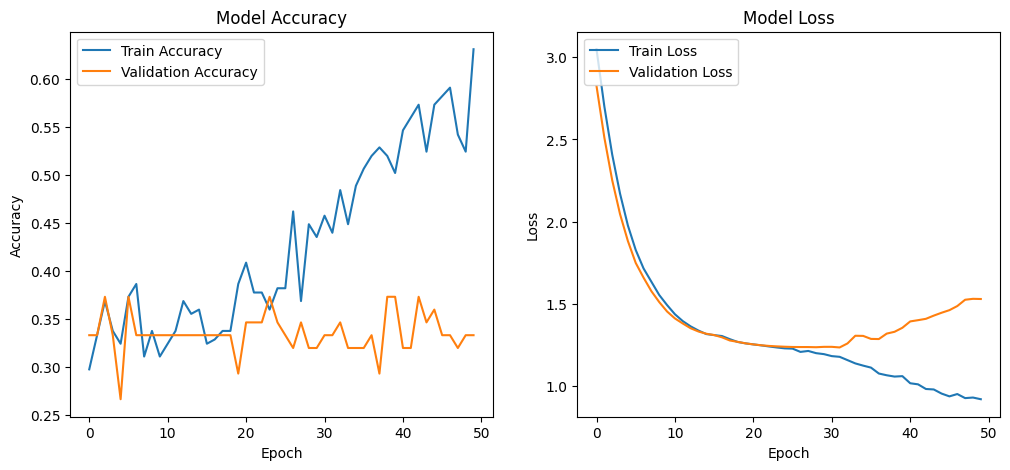

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.regularizers import l2

def build_lstm_model(input_shape, num_classes):
    model = Sequential([
        LSTM(8, return_sequences=True, input_shape=input_shape, kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        LSTM(128, kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Assume video_features is a list of features extracted from video frames,
video_features = extracted_features  # Assuming 'extracted_features' is already loaded and available

# Correct reshaping if number of features is divisible by 30
if len(video_features) % 30 != 0:
    raise ValueError("The number of extracted features is not divisible by the number of timesteps per sequence (30).")

# Reshaping video features to have sequences of 30 timesteps
num_sequences = len(video_features) // 30
video_features = video_features[:num_sequences * 30].reshape(-1, 30, 2048)

# Generate labels for each sequence
labels = np.random.randint(0, 3, num_sequences)  # Adjust 10 to your actual number of classes

# Encoding labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(video_features, labels_categorical, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Defining the input shape and number of classes
input_shape = (30, 2048)  # 30 timesteps, 2048 features each
num_classes = labels_categorical.shape[1]  # Extract number of classes from the one-hot0 encoded labels

# Building and training the model
model = build_lstm_model(input_shape, num_classes)
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=50, batch_size=32, callbacks=[early_stopping, lr_scheduler])

# Plot training & validation accuracy and loss
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


In [ ]:
# Evaluate on validation set
val_predictions = np.argmax(model.predict(X_val), axis=1)
val_accuracy = accuracy_score(np.argmax(y_val, axis=1), val_predictions)
val_f1 = f1_score(np.argmax(y_val, axis=1), val_predictions, average='weighted')

print("Validation Accuracy:", val_accuracy)
print("Validation F1-Score:", val_f1)

# Evaluate on test set
test_predictions = np.argmax(model.predict(X_test), axis=1)
test_accuracy = accuracy_score(np.argmax(y_test, axis=1), test_predictions)
test_f1 = f1_score(np.argmax(y_test, axis=1), test_predictions, average='weighted')

print("Test Accuracy:", test_accuracy)
print("Test F1-Score:", test_f1)


3/3 [==============================] - 1s 14ms/step
Validation Accuracy: 0.3333333333333333
Validation F1-Score: 0.2772778245023829
3/3 [==============================] - 0s 12ms/step
Test Accuracy: 0.4342105263157895
Test F1-Score: 0.3819193794275733


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict probabilities for each class
y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert one-hot encoded labels to class labels
y_true = np.argmax(y_test, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


3/3 [==============================] - 0s 6ms/step
Accuracy: 0.4342105263157895
Precision: 0.5089326225045372
Recall: 0.4342105263157895
F1-score: 0.3819193794275733


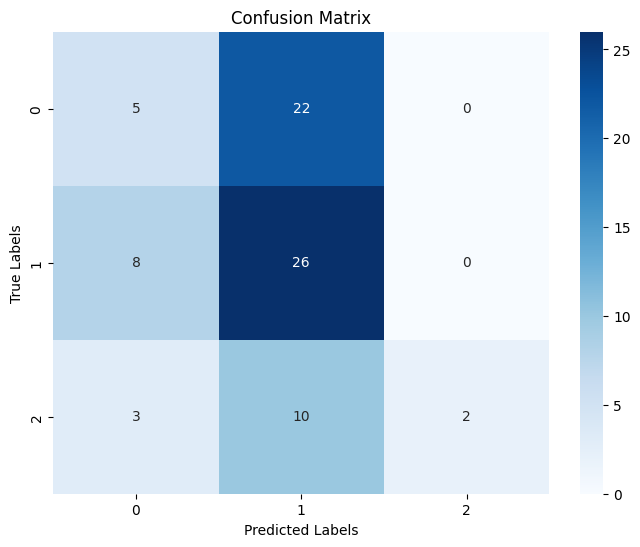

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


3/3 [==============================] - 0s 6ms/step
Accuracy: 0.4342105263157895
              precision    recall  f1-score   support

           0       0.31      0.19      0.23        27
           1       0.45      0.76      0.57        34
           2       1.00      0.13      0.24        15

    accuracy                           0.43        76
   macro avg       0.59      0.36      0.34        76
weighted avg       0.51      0.43      0.38        76



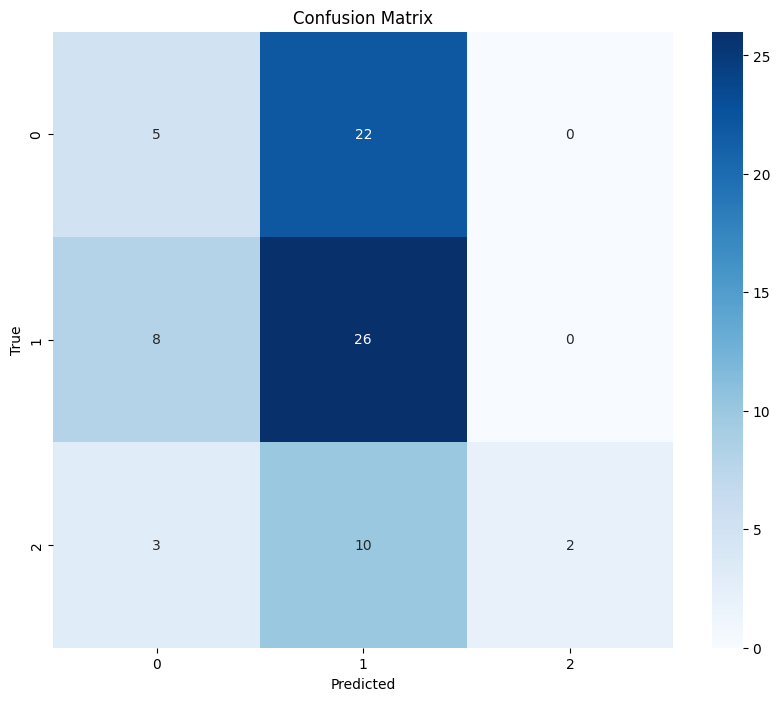

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Predicting the test dataset
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Compute the accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Accuracy: {accuracy}")

# Compute precision, recall, and F1-score
report = classification_report(true_classes, predicted_classes)
print(report)

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
print(extracted_features)

[[0.24060528 0.02012625 0.46252674 ... 0.29789752 1.4997569  0.45240685]
 [0.17574364 0.02963516 0.50554144 ... 0.21128145 1.3181376  0.27242675]
 [0.12285811 0.1481364  0.4868139  ... 0.07998832 0.96395475 0.5121804 ]
 ...
 [0.33760574 0.5019157  0.5130861  ... 0.80957514 0.4692665  0.3058462 ]
 [0.32790783 0.49056903 0.54663146 ... 0.8113847  0.47965473 0.2664753 ]
 [0.36025143 0.50141174 0.55935824 ... 0.81948036 0.49866593 0.28850007]]
